## Step 2 - Parkinsons
- Load in the datasets pulled from the AACT using SQL scripting in R 
- EDA 
- Export clean dataset of generic features



In [ ]:
# Import necessary packages:

import pandas as pd
import numpy as np
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

import scipy.stats as spstats
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load V2_parkinsons dataset AND parkinsons_event_table dataset
pd.set_option('display.max_columns', None)
parkinsons_df = pd.read_csv("/content/drive/MyDrive/HIDS510/Collab Notebooks/Parkinson's Disease Notebooks/V2_parkinsons.csv")
parkinsons_df.head()
event_intervention_df = pd.read_csv("/content/drive/MyDrive/HIDS510/Collab Notebooks/Parkinson's Disease Notebooks/parkinsons_event_table.csv")
event_intervention_df.head()
treatment_type_df = pd.read_csv("/content/drive/MyDrive/HIDS510/Collab Notebooks/Parkinson's Disease Notebooks/parkinsons_treatment_type.csv")
treatment_type_df.head()

,Unnamed: 0,nct_id,intervention_type
0,1,NCT05148468,Device
1,2,NCT05148468,Device
2,3,NCT01155349,Behavioral
3,4,NCT01155349,Other
4,5,NCT02443779,NaN


### Prep Treatment Type table

In [ ]:
# Drop first column of dataframe
treatment_type_df = treatment_type_df.iloc[: , 1:]

# view df 
treatment_type_df.head()

,nct_id,intervention_type
0,NCT05148468,Device
1,NCT05148468,Device
2,NCT01155349,Behavioral
3,NCT01155349,Other
4,NCT02443779,NaN


In [ ]:
# keep only one row if there are identical rows in the dataframe
treatment_type_df = treatment_type_df.drop_duplicates(keep='first')

In [ ]:
# one hot encode intervention_type 
parkinsons_dummy = (pd.concat( (pd.get_dummies(treatment_type_df['intervention_type']), treatment_type_df), axis=1, sort=False)
   .groupby('nct_id', as_index=False, sort=False)
   .agg({'intervention_type': list,'Behavioral':'sum', 'Diagnostic Test':'sum', 'Other':'sum', 'Radiation':'sum', 'Procedure':'sum', 'Device':'sum', 'Dietary Supplement':'sum', 'Genetic':'sum', 'Drug':'sum', 'Biological':'sum'})
)

# drop intervention_type column from anciety_dummy 
parkinsons_dummy_df = parkinsons_dummy.drop(['intervention_type'], axis=1)

In [ ]:
full_df = pd.merge(parkinsons_df, parkinsons_dummy_df, on = 'nct_id')

In [ ]:
full_df

,Unnamed: 0,nct_id,enrollment_total,drop_count_total,study_type,study_phase,number_of_arms,has_expanded_access,has_dmc,number_of_facilities,study_duration_months,number_of_sae_subjects,minimum_age_num,intervention_model_type,allocation_type,masking_type,study_gender_eligibility,health_status_eligibility,Behavioral,Diagnostic Test,Other,Radiation,Procedure,Device,Dietary Supplement,Genetic,Drug,Biological
0,1,NCT05148468,12.0,NaN,Interventional,Not Applicable,2.0,False,True,1.0,NaN,NaN,21.0,Crossover Assignment,Randomized,Quadruple,All,No,0,0,0,0,0,1,0,0,0,0
1,2,NCT01155349,87.0,NaN,Interventional,Phase 3,2.0,False,False,1.0,34.0,NaN,40.0,Parallel Assignment,Randomized,Single,All,No,1,0,1,0,0,0,0,0,0,0
2,3,NCT02443779,7.0,NaN,Observational,NaN,NaN,False,False,1.0,31.0,NaN,50.0,NaN,NaN,NaN,All,No,0,0,0,0,0,0,0,0,0,0
3,4,NCT02390089,158.0,NaN,Interventional,Phase 1,3.0,False,False,1.0,21.0,NaN,50.0,Single Group Assignment,Non-Randomized,Single,All,Accepts Healthy Volunteers,0,0,1,1,0,1,0,0,1,0
4,5,NCT00134784,142.0,7.0,Interventional,Phase 2,1.0,False,False,NaN,86.0,NaN,22.0,Single Group Assignment,NaN,None (Open Label),All,No,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3121,3122,NCT00489255,117.0,68.0,Interventional,Phase 4,2.0,False,False,27.0,55.0,11.0,18.0,Parallel Assignment,Randomized,Double,All,No,0,0,0,0,0,0,0,0,1,0
3122,3123,NCT02670161,3300.0,NaN,Interventional,Phase 4,3.0,False,False,NaN,NaN,NaN,18.0,Parallel Assignment,Non-Randomized,None (Open Label),All,No,0,0,0,0,0,0,0,0,1,0
3123,3124,NCT01998204,62.0,NaN,Observational,NaN,NaN,False,True,1.0,17.0,NaN,18.0,NaN,NaN,NaN,All,No,0,0,0,0,0,0,0,0,0,0
3124,3125,NCT04720365,80.0,NaN,Interventional,Not Applicable,2.0,False,False,1.0,NaN,NaN,18.0,Parallel Assignment,Randomized,None (Open Label),All,No,0,0,0,0,0,1,0,0,0,0


### Create Column with percent Attrition (percent_attrtition)

In [ ]:
#create new column with percent attrition (number_dropped) dividied by (enrollment_total)
full_df["percent_attrition"] = full_df["drop_count_total"]/full_df["enrollment_total"] * 100
full_df.head()

,Unnamed: 0,nct_id,enrollment_total,drop_count_total,study_type,study_phase,number_of_arms,has_expanded_access,has_dmc,number_of_facilities,study_duration_months,number_of_sae_subjects,minimum_age_num,intervention_model_type,allocation_type,masking_type,study_gender_eligibility,health_status_eligibility,Behavioral,Diagnostic Test,Other,Radiation,Procedure,Device,Dietary Supplement,Genetic,Drug,Biological,percent_attrition
0,1,NCT05148468,12.0,NaN,Interventional,Not Applicable,2.0,False,True,1.0,NaN,NaN,21.0,Crossover Assignment,Randomized,Quadruple,All,No,0,0,0,0,0,1,0,0,0,0,NaN
1,2,NCT01155349,87.0,NaN,Interventional,Phase 3,2.0,False,False,1.0,34.0,NaN,40.0,Parallel Assignment,Randomized,Single,All,No,1,0,1,0,0,0,0,0,0,0,NaN
2,3,NCT02443779,7.0,NaN,Observational,NaN,NaN,False,False,1.0,31.0,NaN,50.0,NaN,NaN,NaN,All,No,0,0,0,0,0,0,0,0,0,0,NaN
3,4,NCT02390089,158.0,NaN,Interventional,Phase 1,3.0,False,False,1.0,21.0,NaN,50.0,Single Group Assignment,Non-Randomized,Single,All,Accepts Healthy Volunteers,0,0,1,1,0,1,0,0,1,0,NaN
4,5,NCT00134784,142.0,7.0,Interventional,Phase 2,1.0,False,False,NaN,86.0,NaN,22.0,Single Group Assignment,NaN,None (Open Label),All,No,0,0,0,0,0,0,0,0,1,0,4.929577


In [ ]:
full_df.isna().sum()

Unnamed: 0                      0
nct_id                          0
enrollment_total               27
drop_count_total             2864
study_type                      0
study_phase                   737
number_of_arms                894
has_expanded_access            37
has_dmc                       588
number_of_facilities          313
study_duration_months        1359
number_of_sae_subjects       2906
minimum_age_num               269
intervention_model_type       771
allocation_type              1290
masking_type                  763
study_gender_eligibility        2
health_status_eligibility      65
Behavioral                      0
Diagnostic Test                 0
Other                           0
Radiation                       0
Procedure                       0
Device                          0
Dietary Supplement              0
Genetic                         0
Drug                            0
Biological                      0
percent_attrition            2864
dtype: int64

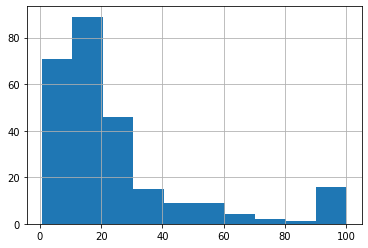

In [ ]:
# Drop first column of dataframe
full_df = full_df.iloc[: , 1:]
#distribution target variable 
#fill infinite values for nan 
full_df['percent_attrition'] = full_df['percent_attrition'].replace(np.inf, np.nan)
full_df.percent_attrition.hist()

#drop 'number_of_sae_subjects' because it has too many missing values to impute with confidence
parkinsons_df_curated = full_df.drop(columns='number_of_sae_subjects')

In [ ]:
parkinsons_df_curated.isna().sum()

nct_id                          0
enrollment_total               27
drop_count_total             2864
study_type                      0
study_phase                   737
number_of_arms                894
has_expanded_access            37
has_dmc                       588
number_of_facilities          313
study_duration_months        1359
minimum_age_num               269
intervention_model_type       771
allocation_type              1290
masking_type                  763
study_gender_eligibility        2
health_status_eligibility      65
Behavioral                      0
Diagnostic Test                 0
Other                           0
Radiation                       0
Procedure                       0
Device                          0
Dietary Supplement              0
Genetic                         0
Drug                            0
Biological                      0
percent_attrition            2864
dtype: int64

### EDA

In [ ]:
#how many studies are included in this parkinsons study investigation
len(full_df.index)
#how many studies have the enrollment total, drop count total, and target variable (percent attrtition)
full_df['enrollment_total'].count(), full_df['drop_count_total'].count(), full_df['percent_attrition'].count()

(3099, 262, 262)

In [ ]:
Counter(full_df['study_phase']) , Counter(full_df['study_gender_eligibility']) , Counter(full_df['health_status_eligibility'])

(Counter({'Early Phase 1': 30,
          'Not Applicable': 1208,
          'Phase 1': 252,
          'Phase 1/Phase 2': 79,
          'Phase 2': 385,
          'Phase 2/Phase 3': 42,
          'Phase 3': 233,
          'Phase 4': 160,
          nan: 737}),
 Counter({'All': 3078, 'Female': 8, 'Male': 38, nan: 2}),
 Counter({'Accepts Healthy Volunteers': 681, 'No': 2380, nan: 65}))

In [ ]:
#get overview description of all columns in df
full_df.describe()

,enrollment_total,drop_count_total,number_of_arms,number_of_facilities,study_duration_months,number_of_sae_subjects,minimum_age_num,Behavioral,Diagnostic Test,Other,Radiation,Procedure,Device,Dietary Supplement,Genetic,Drug,Biological,percent_attrition
count,3.099000e+03,262.000000,2232.000000,2813.000000,1767.000000,220.000000,2857.000000,3126.000000,3126.000000,3126.000000,3126.000000,3126.000000,3126.000000,3126.000000,3126.000000,3126.000000,3126.000000,262.000000
mean,2.952093e+03,58.423664,2.168011,6.836474,25.412564,45.000000,30.229261,0.111964,0.017914,0.218490,0.006718,0.050544,0.176264,0.015995,0.007038,0.350928,0.014715,24.633715
std,1.087683e+05,128.954683,1.244260,21.755583,23.251764,113.971317,13.010942,0.315373,0.132661,0.413288,0.081700,0.219099,0.381105,0.125475,0.083609,0.477337,0.120430,24.140176
min,0.000000e+00,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.732601
25%,2.000000e+01,4.000000,1.000000,1.000000,9.000000,3.750000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.215924
50%,4.500000e+01,16.000000,2.000000,1.000000,20.000000,11.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.104388
75%,1.155000e+02,53.000000,2.000000,2.000000,34.000000,35.250000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,26.828493
max,5.940299e+06,1056.000000,16.000000,317.000000,206.000000,1102.000000,81.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


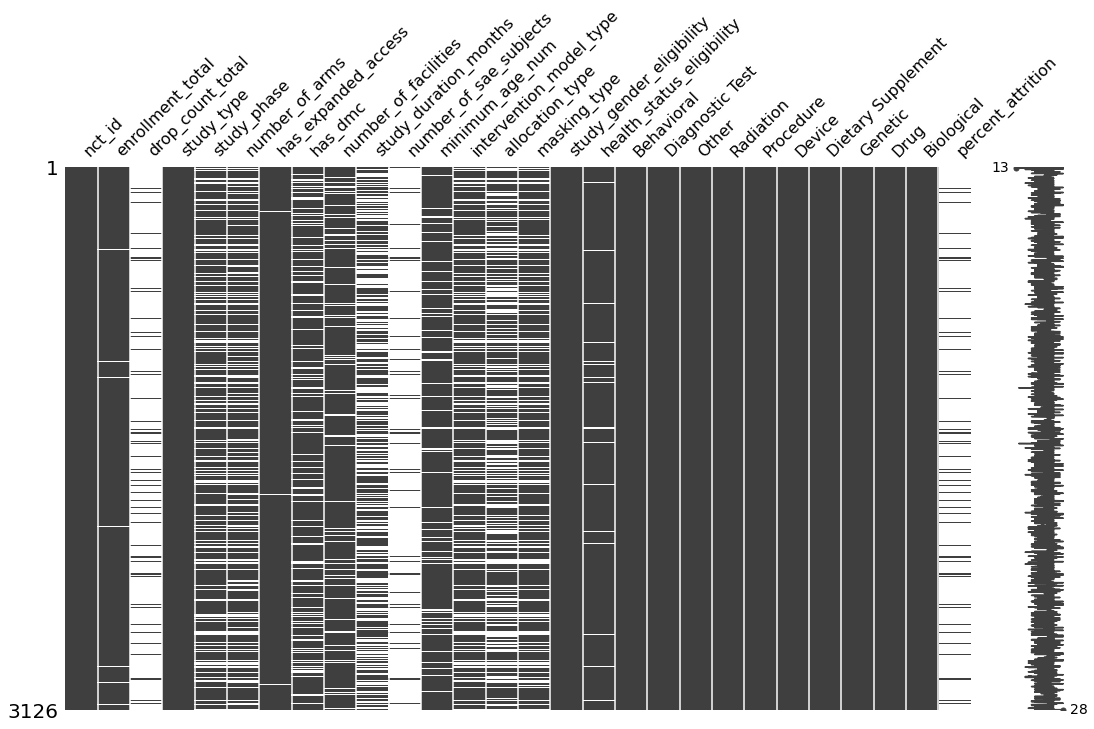

In [ ]:
#visualize missing values
import missingno as msno

missingdata_df = full_df.columns[full_df.isnull().any()].tolist()
msno.matrix(full_df,figsize=(18,10))

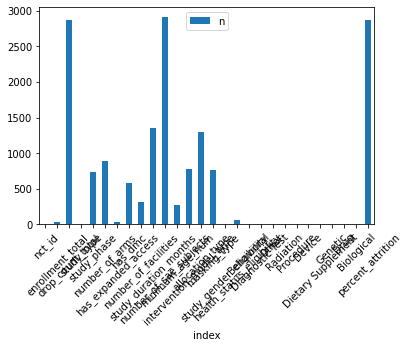

In [ ]:
full_df.isna().sum().reset_index(name="n").plot.bar(x='index', y='n', rot=45)

In [ ]:
full_df.isna().sum()

nct_id                          0
enrollment_total               27
drop_count_total             2864
study_type                      0
study_phase                   737
number_of_arms                894
has_expanded_access            37
has_dmc                       588
number_of_facilities          313
study_duration_months        1359
number_of_sae_subjects       2906
minimum_age_num               269
intervention_model_type       771
allocation_type              1290
masking_type                  763
study_gender_eligibility        2
health_status_eligibility      65
Behavioral                      0
Diagnostic Test                 0
Other                           0
Radiation                       0
Procedure                       0
Device                          0
Dietary Supplement              0
Genetic                         0
Drug                            0
Biological                      0
percent_attrition            2864
dtype: int64

### Create Event columns with event count in respective columns AND convert 

In [ ]:
event_intervention_df.head()
# Drop first column of dataframe
event_intervention_df = event_intervention_df.iloc[: , 1:]

In [ ]:
event_intervention_df

,nct_id,subjects_affected_total,event_type
0,NCT00001215,NaN,NaN
1,NCT00001258,NaN,NaN
2,NCT00001365,NaN,NaN
3,NCT00001549,NaN,NaN
4,NCT00001640,NaN,NaN
...,...,...,...
4111,NCT05415774,NaN,NaN
4112,NCT05418673,NaN,NaN
4113,NCT05419453,NaN,NaN
4114,NCT05421624,NaN,NaN


In [ ]:
# One-hot-encode categorical:
prefix_cols = ['event_type']
dummy_cols = ['event_type']
              
event_df = pd.get_dummies(event_intervention_df, prefix=prefix_cols, columns=dummy_cols)

In [ ]:
event_df.head()

,nct_id,subjects_affected_total,event_type_deaths,event_type_other,event_type_serious
0,NCT00001215,NaN,0,0,0
1,NCT00001258,NaN,0,0,0
2,NCT00001365,NaN,0,0,0
3,NCT00001549,NaN,0,0,0
4,NCT00001640,NaN,0,0,0


In [ ]:
# fill all flag values == 1 with nan
event_df[['event_type_deaths', 'event_type_other', 'event_type_serious']] = event_df[['event_type_deaths', 'event_type_other', 'event_type_serious']].replace(1, np.NaN)

# replace nan values in the three event type columns with the corresponding count value from subjects_affected_total column
event_df.event_type_other.fillna(event_df.subjects_affected_total, inplace=True)
event_df.event_type_deaths.fillna(event_df.subjects_affected_total, inplace=True)
event_df.event_type_serious.fillna(event_df.subjects_affected_total, inplace=True)

#group responses from the merged column (type of event and count) by nct_id
event_total_df = event_df.groupby('nct_id').sum()

#drop column subjects_affected_total 
event_final_df = event_total_df.drop(['subjects_affected_total'], axis=1)

In [ ]:
event_final_df

,event_type_deaths,event_type_other,event_type_serious
nct_id,,,
NCT00001215,0.0,0.0,0.0
NCT00001258,0.0,0.0,0.0
NCT00001365,0.0,0.0,0.0
NCT00001549,0.0,0.0,0.0
NCT00001640,0.0,0.0,0.0
...,...,...,...
NCT05415774,0.0,0.0,0.0
NCT05418673,0.0,0.0,0.0
NCT05419453,0.0,0.0,0.0


In [ ]:
full_df = pd.merge(parkinsons_df_curated, event_final_df, on = 'nct_id')

In [ ]:
full_df

,nct_id,enrollment_total,drop_count_total,study_type,study_phase,number_of_arms,has_expanded_access,has_dmc,number_of_facilities,study_duration_months,minimum_age_num,intervention_model_type,allocation_type,masking_type,study_gender_eligibility,health_status_eligibility,Behavioral,Diagnostic Test,Other,Radiation,Procedure,Device,Dietary Supplement,Genetic,Drug,Biological,percent_attrition,event_type_deaths,event_type_other,event_type_serious
0,NCT05148468,12.0,NaN,Interventional,Not Applicable,2.0,False,True,1.0,NaN,21.0,Crossover Assignment,Randomized,Quadruple,All,No,0,0,0,0,0,1,0,0,0,0,NaN,0.0,0.0,0.0
1,NCT01155349,87.0,NaN,Interventional,Phase 3,2.0,False,False,1.0,34.0,40.0,Parallel Assignment,Randomized,Single,All,No,1,0,1,0,0,0,0,0,0,0,NaN,0.0,0.0,0.0
2,NCT02443779,7.0,NaN,Observational,NaN,NaN,False,False,1.0,31.0,50.0,NaN,NaN,NaN,All,No,0,0,0,0,0,0,0,0,0,0,NaN,0.0,0.0,0.0
3,NCT02390089,158.0,NaN,Interventional,Phase 1,3.0,False,False,1.0,21.0,50.0,Single Group Assignment,Non-Randomized,Single,All,Accepts Healthy Volunteers,0,0,1,1,0,1,0,0,1,0,NaN,0.0,0.0,0.0
4,NCT00134784,142.0,7.0,Interventional,Phase 2,1.0,False,False,NaN,86.0,22.0,Single Group Assignment,NaN,None (Open Label),All,No,0,0,0,0,0,0,0,0,1,0,4.929577,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3121,NCT00489255,117.0,68.0,Interventional,Phase 4,2.0,False,False,27.0,55.0,18.0,Parallel Assignment,Randomized,Double,All,No,0,0,0,0,0,0,0,0,1,0,58.119658,0.0,143.0,10.0
3122,NCT02670161,3300.0,NaN,Interventional,Phase 4,3.0,False,False,NaN,NaN,18.0,Parallel Assignment,Non-Randomized,None (Open Label),All,No,0,0,0,0,0,0,0,0,1,0,NaN,0.0,0.0,0.0
3123,NCT01998204,62.0,NaN,Observational,NaN,NaN,False,True,1.0,17.0,18.0,NaN,NaN,NaN,All,No,0,0,0,0,0,0,0,0,0,0,NaN,0.0,0.0,0.0
3124,NCT04720365,80.0,NaN,Interventional,Not Applicable,2.0,False,False,1.0,NaN,18.0,Parallel Assignment,Randomized,None (Open Label),All,No,0,0,0,0,0,1,0,0,0,0,NaN,0.0,0.0,0.0


### Handle Missing Values

In [ ]:
#impute all non integer missing values with "Not Reported"

#drop all rows that do not have an outcome values (555 studies remain)
full_df.dropna(subset=['percent_attrition'])
#drop all rows that have percent_attrition greater than 100%
df_filtered = full_df[full_df['percent_attrition'] < 100]
#impute all study_phase missing values with "unknown"
df_filtered[['study_phase', 'intervention_model_type', 'allocation_type', 'masking_type']] = df_filtered[['study_phase', 'intervention_model_type', 'allocation_type', 'masking_type']].fillna('Not Reported')
#fill nan values in had_dmc column with false 
df_filtered['has_dmc'] = df_filtered['has_dmc'].fillna(False)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
df_filtered.isna().sum()

nct_id                        0
enrollment_total              0
drop_count_total              0
study_type                    0
study_phase                   0
number_of_arms               25
has_expanded_access           3
has_dmc                       0
number_of_facilities         22
study_duration_months         1
minimum_age_num              20
intervention_model_type       0
allocation_type               0
masking_type                  0
study_gender_eligibility      0
health_status_eligibility     1
Behavioral                    0
Diagnostic Test               0
Other                         0
Radiation                     0
Procedure                     0
Device                        0
Dietary Supplement            0
Genetic                       0
Drug                          0
Biological                    0
percent_attrition             0
event_type_deaths             0
event_type_other              0
event_type_serious            0
dtype: int64

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name_

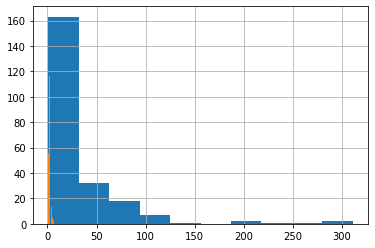

In [ ]:
#visulalize data to determine imputation with mean or median
df_filtered.number_of_facilities.hist(), df_filtered.number_of_arms.hist()

#impute all integer missing values with median (because of large skew to these two features)
df_filtered.fillna(df_filtered['number_of_facilities'].median(), inplace = True)
df_filtered.fillna(df_filtered['number_of_arms'].median(), inplace = True)

#impute all missing values from minimum_age_num with 1000 as place holder for 'Not Reported'
df_filtered['minimum_age_num'] = df_filtered['minimum_age_num'].fillna(1000)

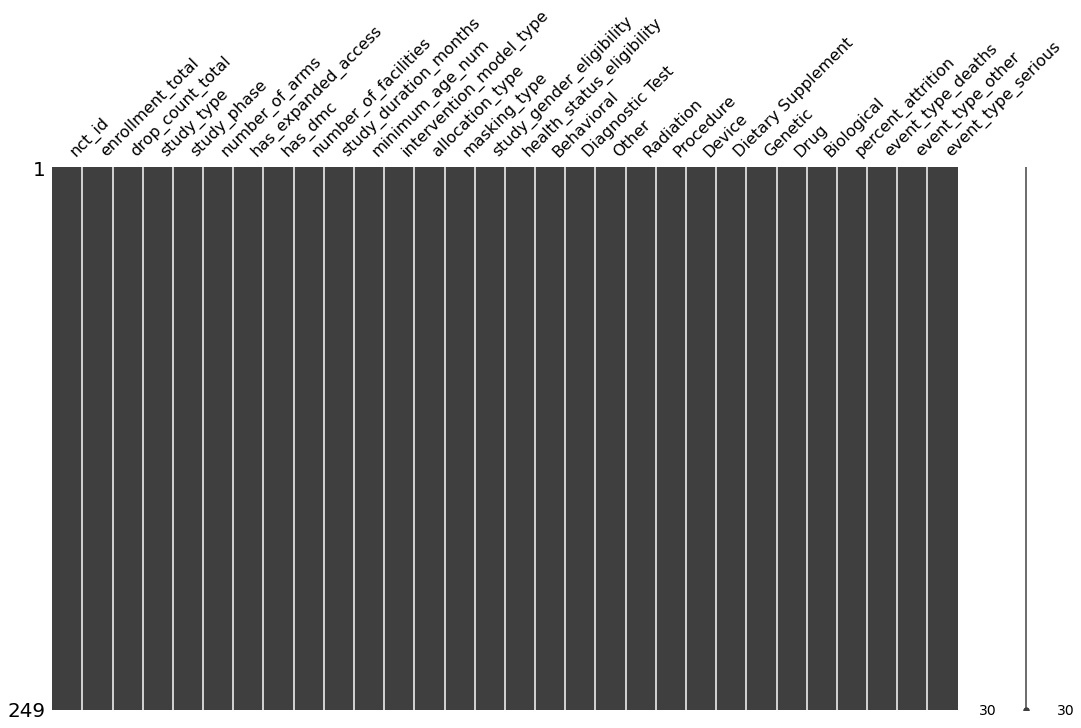

In [ ]:
#count missing values
df_filtered.isna().sum()
 
#visualize missing values
missingdata_df = df_filtered.columns[df_filtered.isnull().any()].tolist()
msno.matrix(df_filtered,figsize=(18,10))

### Categorize minimum_age column to pediatric / non-pediatric

In [ ]:
#categorize minimum_age_num into three categories "pediatric", "Not Pediatric", or "Not Reported"
df_filtered['minimum_age_num'] = pd.cut(x=df_filtered['minimum_age_num'], bins=[0, 17, 150, 1000],
                     labels=['Pediatric Subjects Included', 'No Pediatric Subjects Included', 'Not Reported'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_filtered.shape

(249, 30)

In [ ]:
df_filtered.head()

,nct_id,enrollment_total,drop_count_total,study_type,study_phase,number_of_arms,has_expanded_access,has_dmc,number_of_facilities,study_duration_months,minimum_age_num,intervention_model_type,allocation_type,masking_type,study_gender_eligibility,health_status_eligibility,Behavioral,Diagnostic Test,Other,Radiation,Procedure,Device,Dietary Supplement,Genetic,Drug,Biological,percent_attrition,event_type_deaths,event_type_other,event_type_serious
4,NCT00134784,142.0,7.0,Interventional,Phase 2,1.0,False,False,11.0,86.0,No Pediatric Subjects Included,Single Group Assignment,Not Reported,None (Open Label),All,No,0,0,0,0,0,0,0,0,1,0,4.929577,0.0,0.0,0.0
5,NCT00753519,28.0,2.0,Interventional,Phase 1/Phase 2,2.0,False,False,1.0,12.0,No Pediatric Subjects Included,Parallel Assignment,Randomized,Double,All,No,0,0,0,0,0,1,0,0,0,0,7.142857,0.0,2.0,1.0
10,NCT00350402,44.0,2.0,Interventional,Phase 2,2.0,False,True,1.0,59.0,No Pediatric Subjects Included,Parallel Assignment,Randomized,Double,All,No,1,0,0,0,0,0,0,0,0,0,4.545455,0.0,0.0,0.0
12,NCT00501969,395.0,206.0,Interventional,Phase 3,1.0,False,False,53.0,52.0,No Pediatric Subjects Included,Single Group Assignment,Not Reported,None (Open Label),All,No,0,0,0,0,0,0,0,0,1,0,52.151899,0.0,305.0,148.0
13,NCT01494532,352.0,58.0,Interventional,Phase 4,2.0,False,False,52.0,32.0,No Pediatric Subjects Included,Parallel Assignment,Randomized,Double,All,No,0,0,0,0,0,0,0,0,1,0,16.477273,0.0,161.0,4.0


### Classify outcome variable into low, medium, high atttrition levels 

In [ ]:
MIN = 100
MAX = 0
df_filtered['percent_attrition'].sub(MIN).div(MAX-MIN).clip(0, 1)

4       0.950704
5       0.928571
10      0.954545
12      0.478481
13      0.835227
          ...   
3063    0.992674
3071    0.500000
3084    0.952663
3088    0.746667
3121    0.418803
Name: percent_attrition, Length: 249, dtype: float64

Text(0, 0.5, 'Frequency')

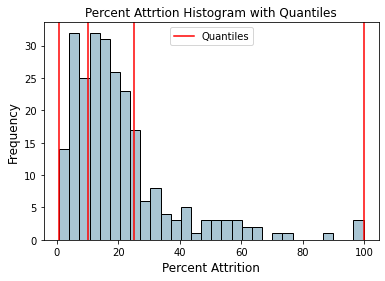

In [ ]:
quantile_list = [0, .25, .75, 1.]
quantiles = df_filtered['percent_attrition'].quantile(quantile_list)
quantiles

fig, ax = plt.subplots()
df_filtered['percent_attrition'].hist(bins=30, color='#A9C5D3', 
                             edgecolor='black', grid=False)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color='r')
ax.legend([qvl], ['Quantiles'], fontsize=10)
ax.set_title('Percent Attrtion Histogram with Quantiles', 
             fontsize=12)
ax.set_xlabel('Percent Attrition', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [ ]:
quantile_labels = ['0-25Q', '25-75Q', '75-100Q']
df_filtered['quantile_attrition_range'] = pd.qcut(
                                            df_filtered['percent_attrition'], 
                                            q=quantile_list)
df_filtered['quantile_attrition_range'] = pd.qcut(
                                            df_filtered['percent_attrition'], 
                                            q=quantile_list,       
                                            labels=quantile_labels)
df_filtered

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,nct_id,enrollment_total,drop_count_total,study_type,study_phase,number_of_arms,has_expanded_access,has_dmc,number_of_facilities,study_duration_months,minimum_age_num,intervention_model_type,allocation_type,masking_type,study_gender_eligibility,health_status_eligibility,Behavioral,Diagnostic Test,Other,Radiation,Procedure,Device,Dietary Supplement,Genetic,Drug,Biological,percent_attrition,event_type_deaths,event_type_other,event_type_serious,quantile_attrition_range
4,NCT00134784,142.0,7.0,Interventional,Phase 2,1.0,False,False,11.0,86.0,No Pediatric Subjects Included,Single Group Assignment,Not Reported,None (Open Label),All,No,0,0,0,0,0,0,0,0,1,0,4.929577,0.0,0.0,0.0,0-25Q
5,NCT00753519,28.0,2.0,Interventional,Phase 1/Phase 2,2.0,False,False,1.0,12.0,No Pediatric Subjects Included,Parallel Assignment,Randomized,Double,All,No,0,0,0,0,0,1,0,0,0,0,7.142857,0.0,2.0,1.0,0-25Q
10,NCT00350402,44.0,2.0,Interventional,Phase 2,2.0,False,True,1.0,59.0,No Pediatric Subjects Included,Parallel Assignment,Randomized,Double,All,No,1,0,0,0,0,0,0,0,0,0,4.545455,0.0,0.0,0.0,0-25Q
12,NCT00501969,395.0,206.0,Interventional,Phase 3,1.0,False,False,53.0,52.0,No Pediatric Subjects Included,Single Group Assignment,Not Reported,None (Open Label),All,No,0,0,0,0,0,0,0,0,1,0,52.151899,0.0,305.0,148.0,75-100Q
13,NCT01494532,352.0,58.0,Interventional,Phase 4,2.0,False,False,52.0,32.0,No Pediatric Subjects Included,Parallel Assignment,Randomized,Double,All,No,0,0,0,0,0,0,0,0,1,0,16.477273,0.0,161.0,4.0,25-75Q
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3063,NCT00382967,273.0,2.0,Interventional,Phase 4,2.0,False,True,2.0,51.0,No Pediatric Subjects Included,Parallel Assignment,Randomized,None (Open Label),All,No,0,0,0,0,1,0,0,0,0,0,0.732601,0.0,0.0,0.0,0-25Q
3071,NCT03630302,10.0,5.0,Observational,Not Reported,11.0,False,False,1.0,17.0,No Pediatric Subjects Included,Not Reported,Not Reported,Not Reported,All,11.0,0,0,0,0,0,1,0,0,0,0,50.000000,0.0,2.0,0.0,75-100Q
3084,NCT01639469,169.0,8.0,Interventional,Not Applicable,2.0,False,False,1.0,38.0,No Pediatric Subjects Included,Parallel Assignment,Randomized,Single,All,No,1,0,0,0,0,0,0,0,0,0,4.733728,6.0,0.0,6.0,0-25Q
3088,NCT00165789,75.0,19.0,Interventional,Phase 2,11.0,False,False,10.0,5.0,No Pediatric Subjects Included,Parallel Assignment,Randomized,Double,All,No,0,0,0,0,0,0,0,0,1,0,25.333333,0.0,65.0,8.0,75-100Q


In [ ]:
# specifying bins and allowing the qcut function to divide the data
#pd.qcut(df_filtered['percent_attrition'], q=3)

#check values counts in each bin 
#pd.qcut(df_filtered['percent_attrition'], q=3).value_counts()

#cut_category = ['Low Attrition', 'Medium Attrition', 'High Attrition']
#cut_bins =[0, 13.160, 25.86, 92.1]
#df_filtered['quantile_attrition_range'] = pd.cut(df_filtered['percent_attrition'], bins=cut_bins, labels = cut_category)

### Export clean Parkinsons File

In [ ]:
df_filtered['percent_attrition'].describe()
#download cleaned data 
df_filtered.to_csv("/content/drive/MyDrive/HIDS510/Collab Notebooks/Parkinson's Disease Notebooks/parkinsons_clean_df.csv")